In [68]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.colors as mcolors
import cmcrameri.cm as cmc
from tqdm import tqdm
from pathlib import Path

In [12]:
# --- Parameters ---
num_fils = 309
num_segs = 20
num_steps = 500
sphere_radius = 197.6 

# --- File Paths ---
# Make sure to use the correct simulation data path
sim_name = 'yes_tilt_1'
date = '20250806'
base_path = f'../data/{sim_name}/{date}/ciliate_309fil_18000blob_8.00R_0.1500torsion_0.2182tilt_0.3000f_eff_1.4960theta0_0.0000freqshift'
seg_file_path = f'{base_path}_seg_states.dat'
phase_file_path = f'{base_path}_true_states.dat'

# --- Load Data ---
seg_data = np.loadtxt(seg_file_path)
phase_data = np.loadtxt(phase_file_path)

# --- Process Data ---
time = phase_data[:, 0] / num_steps
num_steps = len(time)

# Reshape segment data: (time, num_fils, num_segs, 3)
seg_positions = seg_data[:, 1:].reshape(num_steps, num_fils, num_segs, 3)

# Extract phases: (time, num_fils)
phases = np.mod(phase_data[:, 2:num_fils+2], 2*np.pi)

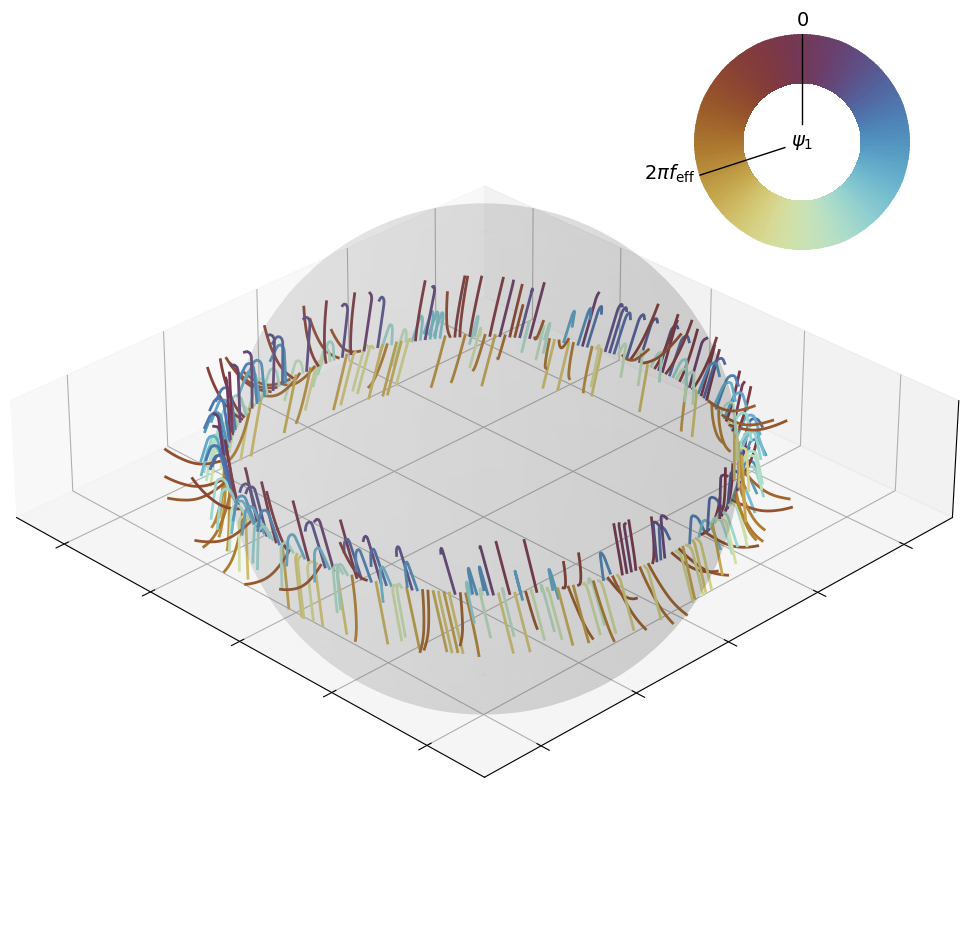

In [54]:
plt.rcParams.update({
    # "text.usetex": True,
    # "font.family": "serif",
    "font.size": 20  # Set the font size here
})

# --- Preview First Frame ---
fig_preview = plt.figure(figsize=(12, 12))
ax_preview = fig_preview.add_subplot(111, projection='3d')

# Setup colormap
cmap = cmc.romaO
norm = mcolors.Normalize(vmin=0, vmax=2*np.pi)

# Plot the sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = sphere_radius * np.outer(np.cos(u), np.sin(v))
y_sphere = sphere_radius * np.outer(np.sin(u), np.sin(v))
z_sphere = sphere_radius * np.outer(np.ones(np.size(u)), np.cos(v))
ax_preview.plot_surface(x_sphere, y_sphere, z_sphere, color='grey', alpha=0.1)

# Set axis limits based on the initial positions of the cilia
x_coords = seg_positions[0, :, :, 0]
y_coords = seg_positions[0, :, :, 1]
z_coords = seg_positions[0, :, :, 2]

margin = 2.0
ax_preview.set_xlim(np.min(x_coords) - margin, np.max(x_coords) + margin)
ax_preview.set_ylim(np.min(y_coords) - margin, np.max(y_coords) + margin)
ax_preview.set_zlim(np.min(z_coords) - margin, np.max(z_coords) + margin)

ax_preview.set_xlabel('')
ax_preview.set_ylabel('')
ax_preview.set_zlabel('')
ax_preview.set_xticklabels([])
ax_preview.set_yticklabels([])
ax_preview.set_zticklabels([])
ax_preview.set_title(r'')
ax_preview.set_aspect('equal')
ax_preview.grid(True, alpha=0.3)

# Hide z-ticks
ax_preview.set_zticks([])

# Set view angle for isometric view
ax_preview.view_init(elev=30, azim=-45)

# Plot each cilium for the first frame
for i in range(num_fils):
    cilium_positions = seg_positions[0, i, :, :]
    x_data = cilium_positions[:, 0]
    y_data = cilium_positions[:, 1]
    z_data = cilium_positions[:, 2]
    ax_preview.plot(x_data, y_data, z_data, '-', lw=2, color=cmap(norm(phases[0, i])))

# Add a colorbar
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = fig_preview.colorbar(sm, ax=ax_preview, orientation='vertical', fraction=0.046, pad=0.05)
# cbar.set_label(r'$\psi_1$', rotation=0, labelpad=-30, va='center')
# # Set custom ticks for the colorbar
# cbar.set_ticks([0, 0.6*np.pi, 2*np.pi])
# cbar.set_ticklabels([r'$0$', r'$2\pi f_{\mathrm{eff}}$', r'$2\pi$'])

# Replace the rectangular colorbar with a circular inset legend
# (maps angle θ to ψ1 in [0, 2π])
# sm/cbar removed

# Place a polar inset in the top-right of the 3D axes
fig_preview.canvas.draw()  # ensure bbox is valid before querying
bbox = ax_preview.get_position()  # figure coords [0..1]
side = 0.18                       # inset size (fraction of figure)
pad  = 0.02                       # padding from top-right

# Clamp so left/bottom are finite and in [0, 1-side]
left   = np.clip(bbox.x1 - side - pad, 0.0, 1.0 - side)
bottom = np.clip(bbox.y1 - side - pad, 0.0, 1.0 - side)
circ = fig_preview.add_axes([left, bottom, side, side], projection='polar')

# Build a colored ring
theta = np.linspace(0, 2*np.pi, 361)
r = np.linspace(0.82, 1.00, 2)    # thin ring
Theta, R = np.meshgrid(theta, r)
Z = Theta                          # values -> colormap in [0, 2π]
im_circ = circ.pcolormesh(Theta, R, Z, cmap=cmap, shading='auto', vmin=0, vmax=2*np.pi)

# Style the circular legend
circ.set_yticks([]); circ.set_xticks([])
circ.spines['polar'].set_visible(False)
circ.set_theta_zero_location('N')
circ.set_theta_direction(-1)
circ.set_rlim(0.78, 1.02)

# Center label in axes coords (avoid polar-data transform issues)
circ.text(0.5, 0.5, r'$\psi_1$', ha='center', va='center', fontsize=14, transform=circ.transAxes)

# Build a colored ring
theta = np.linspace(0, 2*np.pi, 361)
r_inner, r_outer = 0.82, 1.50
Theta, R = np.meshgrid(theta, np.linspace(r_inner, r_outer, 2))
Z = Theta
im_circ = circ.pcolormesh(Theta, R, Z, cmap=cmap, shading='auto', vmin=0, vmax=2*np.pi)

# Style the circular legend
circ.set_yticks([]); circ.set_xticks([])
circ.spines['polar'].set_visible(False)
circ.set_theta_zero_location('N')
circ.set_theta_direction(1)
circ.set_rlim(0.78, 1.02)

# --- Add radial lines and labels at ψ1 = 0 and ψ1 = 2π f_eff ---
theta0 = 0.0
theta_eff = 0.6*np.pi  # same angle you used for the colorbar tick (2π f_eff)

# Guide lines
circ.plot([theta0, theta0],   [r_inner, r_outer], color='k', lw=1.0, zorder=10)
circ.plot([theta_eff, theta_eff], [r_inner, r_outer], color='k', lw=1.0, zorder=10)

# Labels farther from the center (keep <= rlim max)
r_label = 1.1
circ.text(theta0,  1.03, r'$0$', ha='center', va='bottom', fontsize=14,
          transform=circ.transData, clip_on=False, zorder=11)
circ.text(theta_eff, 1.09, r'$2\pi f_{\mathrm{eff}}$', ha='center', va='bottom', fontsize=14,
          transform=circ.transData, clip_on=False, zorder=11)

plt.show()

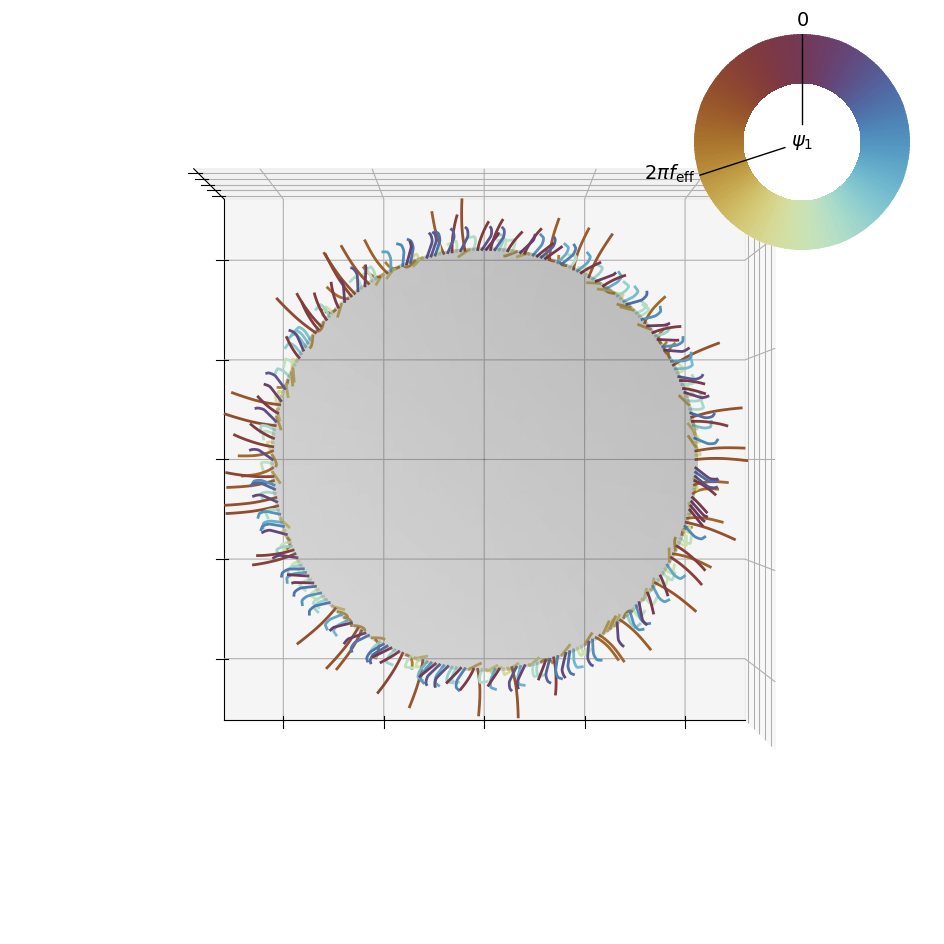

In [ ]:
# Compute global bounds once so preview matches the video framing
x_all = seg_positions[..., 0]
y_all = seg_positions[..., 1]
z_all = seg_positions[..., 2]
margin = 2.0
xlim = (float(np.min(x_all)) - margin, float(np.max(x_all)) + margin)
ylim = (float(np.min(y_all)) - margin, float(np.max(y_all)) + margin)
zlim = (float(np.min(z_all)) - margin, float(np.max(z_all)) + margin)

# Colormap
cmap = cmc.romaO
norm = mcolors.Normalize(vmin=0, vmax=2*np.pi)

# Figure
fig_td = plt.figure(figsize=(12, 12))
ax_td = fig_td.add_subplot(111, projection='3d')

# Axes limits and top-down view
ax_td.set_xlim(*xlim)
ax_td.set_ylim(*ylim)
ax_td.set_zlim(*zlim)
ax_td.view_init(elev=90, azim=-90)  # top-down
ax_td.set_box_aspect((1, 1, 1))
# ax_td.grid(False)  # grid off to keep background clean

# Hide all axis labels/ticks
ax_td.set_xlabel('')
ax_td.set_ylabel('')
ax_td.set_zlabel('')
ax_td.set_xticklabels([])
ax_td.set_yticklabels([])
ax_td.set_zticklabels([])

# Plot the sphere (light)
u = np.linspace(0, 2*np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = sphere_radius * np.outer(np.cos(u), np.sin(v))
y_sphere = sphere_radius * np.outer(np.sin(u), np.sin(v))
z_sphere = sphere_radius * np.outer(np.ones(np.size(u)), np.cos(v))
ax_td.plot_surface(x_sphere, y_sphere, z_sphere, color='grey', alpha=0.15, linewidth=0, antialiased=True)

# Plot each cilium at frame 0
frame = 0
for i in range(num_fils):
    XYZ = seg_positions[frame, i, :, :]
    ax_td.plot(XYZ[:, 0], XYZ[:, 1], XYZ[:, 2], '-', lw=2, color=cmap(norm(phases[frame, i])))

# Circular legend (with radial guides)
fig_td.canvas.draw()
bbox = ax_td.get_position()
side = 0.18
pad  = 0.02
left   = np.clip(bbox.x1 - side - pad, 0.0, 1.0 - side)
bottom = np.clip(bbox.y1 - side - pad, 0.0, 1.0 - side)
circ = fig_td.add_axes([left, bottom, side, side], projection='polar')

# Build a colored ring
theta = np.linspace(0, 2*np.pi, 361)
r = np.linspace(0.82, 1.00, 2)    # thin ring
Theta, R = np.meshgrid(theta, r)
Z = Theta                          # values -> colormap in [0, 2π]
im_circ = circ.pcolormesh(Theta, R, Z, cmap=cmap, shading='auto', vmin=0, vmax=2*np.pi)

# Style the circular legend
circ.set_yticks([]); circ.set_xticks([])
circ.spines['polar'].set_visible(False)
circ.set_theta_zero_location('N')
circ.set_theta_direction(-1)
circ.set_rlim(0.78, 1.02)

# Center label in axes coords (avoid polar-data transform issues)
circ.text(0.5, 0.5, r'$\psi_1$', ha='center', va='center', fontsize=14, transform=circ.transAxes)

# Build a colored ring
theta = np.linspace(0, 2*np.pi, 361)
r_inner, r_outer = 0.82, 1.50
Theta, R = np.meshgrid(theta, np.linspace(r_inner, r_outer, 2))
Z = Theta
im_circ = circ.pcolormesh(Theta, R, Z, cmap=cmap, shading='auto', vmin=0, vmax=2*np.pi)

# Style the circular legend
circ.set_yticks([]); circ.set_xticks([])
circ.spines['polar'].set_visible(False)
circ.set_theta_zero_location('N')
circ.set_theta_direction(1)
circ.set_rlim(0.78, 1.02)

# --- Add radial lines and labels at ψ1 = 0 and ψ1 = 2π f_eff ---
theta0 = 0.0
theta_eff = 0.6*np.pi  # same angle you used for the colorbar tick (2π f_eff)

# Guide lines
circ.plot([theta0, theta0],   [r_inner, r_outer], color='k', lw=1.0, zorder=10)
circ.plot([theta_eff, theta_eff], [r_inner, r_outer], color='k', lw=1.0, zorder=10)

# Labels farther from the center (keep <= rlim max)
r_label = 1.1
circ.text(theta0,  1.03, r'$0$', ha='center', va='bottom', fontsize=14,
          transform=circ.transData, clip_on=False, zorder=11)
circ.text(theta_eff, 1.09, r'$2\pi f_{\mathrm{eff}}$', ha='center', va='bottom', fontsize=14,
          transform=circ.transData, clip_on=False, zorder=11)

plt.show()

In [ ]:
# Reuse: seg_positions, phases, sphere_radius, num_fils, sim_name

# Global bounds (same as preview)
x_all = seg_positions[..., 0]
y_all = seg_positions[..., 1]
z_all = seg_positions[..., 2]
margin = 2.0
xlim = (float(np.min(x_all)) - margin, float(np.max(x_all)) + margin)
ylim = (float(np.min(y_all)) - margin, float(np.max(y_all)) + margin)
zlim = (float(np.min(z_all)) - margin, float(np.max(z_all)) + margin)

# Colormap
cmap = cmc.romaO
norm = mcolors.Normalize(vmin=0, vmax=2*np.pi)

# Figure/axes
fig_anim = plt.figure(figsize=(12, 12))
ax_anim = fig_anim.add_subplot(111, projection='3d')

# Axes limits and top-down view (MATCH Cell 4)
ax_anim.set_xlim(*xlim)
ax_anim.set_ylim(*ylim)
ax_anim.set_zlim(*zlim)
ax_anim.view_init(elev=90, azim=-90)  # top-down
ax_anim.set_box_aspect((1, 1, 1))
ax_anim.grid(True, alpha=0.3)

# Hide all axis labels/ticks (MATCH Cell 4)
ax_anim.set_xlabel('')
ax_anim.set_ylabel('')
ax_anim.set_zlabel('')
ax_anim.set_xticklabels([])
ax_anim.set_yticklabels([])
ax_anim.set_zticklabels([])

# Plot the sphere (light, MATCH Cell 4)
u = np.linspace(0, 2*np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = sphere_radius * np.outer(np.cos(u), np.sin(v))
y_sphere = sphere_radius * np.outer(np.sin(u), np.sin(v))
z_sphere = sphere_radius * np.outer(np.ones(np.size(u)), np.cos(v))
ax_anim.plot_surface(x_sphere, y_sphere, z_sphere, color='grey',
                     alpha=0.15, linewidth=0, antialiased=True)

# Line artists for cilia
lines = [ax_anim.plot([], [], [], '-', lw=2)[0] for _ in range(num_fils)]

def init_anim():
    for ln in lines:
        ln.set_data([], [])
        ln.set_3d_properties([])
    return lines

def update_anim(frame):
    XYZ = seg_positions[frame]  # (num_fils, num_segs, 3)
    for i, ln in enumerate(lines):
        ln.set_data(XYZ[i, :, 0], XYZ[i, :, 1])
        ln.set_3d_properties(XYZ[i, :, 2])
        ln.set_color(cmap(norm(phases[frame, i])))
    return lines

# Circular legend (MATCH Cell 4)
fig_anim.canvas.draw()
bbox = ax_anim.get_position()
side = 0.18
pad  = 0.02
left   = np.clip(bbox.x1 - side - pad, 0.0, 1.0 - side)
bottom = np.clip(bbox.y1 - side - pad, 0.0, 1.0 - side)
circ = fig_anim.add_axes([left, bottom, side, side], projection='polar')

# Build a colored ring (thin ring)
theta = np.linspace(0, 2*np.pi, 361)
r = np.linspace(0.82, 1.00, 2)
Theta, R = np.meshgrid(theta, r)
Z = Theta
circ.pcolormesh(Theta, R, Z, cmap=cmap, shading='auto', vmin=0, vmax=2*np.pi)

# Style the circular legend
circ.set_yticks([]); circ.set_xticks([])
circ.spines['polar'].set_visible(False)
circ.set_theta_zero_location('N')
circ.set_theta_direction(-1)
circ.set_rlim(0.78, 1.02)

# Center label
circ.text(0.5, 0.5, r'$\psi_1$', ha='center', va='center', fontsize=14, transform=circ.transAxes)

# (Second pass, as in Cell 4)
theta = np.linspace(0, 2*np.pi, 361)
r_inner, r_outer = 0.82, 1.50
Theta, R = np.meshgrid(theta, np.linspace(r_inner, r_outer, 2))
Z = Theta
circ.pcolormesh(Theta, R, Z, cmap=cmap, shading='auto', vmin=0, vmax=2*np.pi)

# Final legend style (MATCH Cell 4)
circ.set_yticks([]); circ.set_xticks([])
circ.spines['polar'].set_visible(False)
circ.set_theta_zero_location('N')
circ.set_theta_direction(1)      # same as preview
circ.set_rlim(0.78, 1.02)

# Radial lines and labels (MATCH Cell 4)
theta0 = 0.0
theta_eff = 0.6*np.pi
circ.plot([theta0, theta0], [r_inner, r_outer], color='k', lw=1.0, zorder=10)
circ.plot([theta_eff, theta_eff], [r_inner, r_outer], color='k', lw=1.0, zorder=10)
circ.text(theta0,   1.03, r'$0$', ha='center', va='bottom', fontsize=14,
          transform=circ.transData, clip_on=False, zorder=11)
circ.text(theta_eff, 1.09, r'$2\pi f_{\mathrm{eff}}$', ha='center', va='bottom', fontsize=14,
          transform=circ.transData, clip_on=False, zorder=11)

# Animate and save
stride = 10
frames = range(0, seg_positions.shape[0], stride)
fps = 25

out_dir = Path("analysis_output"); out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / f"{sim_name}_topdown.mp4"

ani = FuncAnimation(fig_anim, update_anim, frames=frames, init_func=init_anim, blit=False)

writer = FFMpegWriter(fps=fps, metadata=dict(artist="cuda-filaments"))
with tqdm(total=len(frames), desc=f"Rendering {out_path.name}") as pbar:
    ani.save(out_path.as_posix(), writer=writer,
             progress_callback=lambda i, n: pbar.update(1))

plt.close(fig_anim)
print(f"Saved: {out_path}")

Rendering yes_tilt_1_topdown.mp4: 100%|██████████| 2001/2001 [11:33<00:00,  2.89it/s]

Saved: analysis_output/yes_tilt_1_topdown.mp4
